In [52]:
import pandas as pd
import numpy as np
from numpy import asarray
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import pydotplus as pyd

import keras
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.utils import to_categorical
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dense, Input, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, concatenate

%matplotlib inline

# Dataset - I

In [53]:
train_data = pd.read_csv('/kaggle/input/tweets/clean_train.csv')
test_data = pd.read_csv('/kaggle/input/tweets/clean_test.csv')
train_data.head()

,text,label
0,that rutgers game was an abomination an affron...,anger
1,i get mad over something so minuscule i try to...,anger
2,i get mad over something so minuscule i try to...,anger
3,eyes have been dilated i hate the world right ...,anger
4,one chosen by the clp members mp seats are not...,anger


In [54]:
train_data['label'].value_counts()

fear       569
joy        416
anger      409
sadness    396
Name: label, dtype: int64

In [55]:
train_data['label'] = train_data['label'].apply(lambda x: ['fear', 'joy', 'anger', 'sadness'].index(x))
test_data['label'] = test_data['label'].apply(lambda x: ['fear', 'joy', 'anger', 'sadness'].index(x))

train_data['text'] = train_data['text'].apply(str)
test_data['text'] = test_data['text'].apply(str)

In [56]:
X_train = train_data['text'].values
X_test = test_data['text'].values

y_train = train_data['label'].values
y_test = test_data['label'].values

X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [57]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 455, 1: 333, 2: 327, 3: 317}

In [58]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 471, 1: 356, 2: 348, 3: 327}

In [59]:
unique, counts = np.unique(y_cv, return_counts=True)
dict(zip(unique, counts))

{0: 114, 1: 83, 2: 82, 3: 79}

In [60]:
t = Tokenizer()
t.fit_on_texts(X_train)
vocab_size = len(t.word_index) + 1
print(vocab_size)

4702


In [61]:
encoded_train = t.texts_to_sequences(X_train)
encoded_cv = t.texts_to_sequences(X_cv)
encoded_test = t.texts_to_sequences(X_test)

In [62]:
max_length = 140
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_cv = pad_sequences(encoded_cv, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')

In [63]:
y_train = to_categorical(y_train, num_classes=4)
y_cv = to_categorical(y_cv, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [64]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('/kaggle/input/glove-twitter-27b-200d-txt/glove.twitter.27B.200d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


In [65]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 200))
for word, i in t.word_index.items():
    try:
        embedding_vector = embeddings_index[word]
    except:
        embedding_vector = [0]*200
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

(4702, 200)

In [66]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [67]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=3, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=2, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(150, activation='relu', name='fully_connected')(flatten)
out = Dense(4, activation='softmax')(dense)

model_01 = Model(inputs=[input_data], outputs=[out])

print(model_01.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 140)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 140, 200)          940400    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 138, 50)           30050     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 69, 50)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 68, 100)           10100     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 34, 100)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3400)              0   

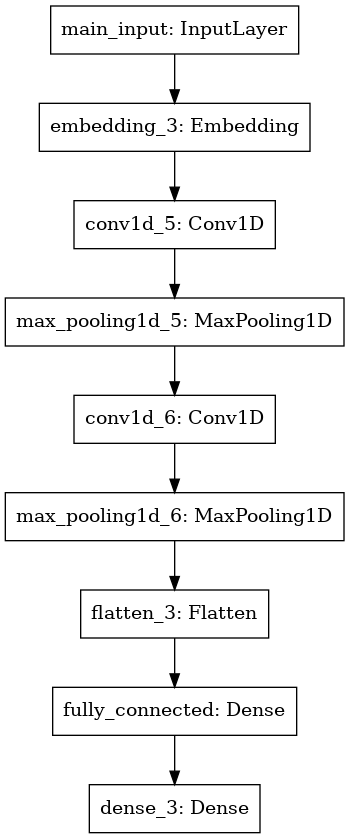

In [68]:
keras.utils.vis_utils.pydot = pyd
plot_model(model_01, to_file='model_01.png')

In [69]:
reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("emotion_model_1_1.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 5,
                            verbose=1)

In [70]:
c = optimizers.Adam(lr = 0.0001)
model_01.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

h1 = model_01.fit(padded_train, y_train, 
               batch_size=16, 
               epochs=50, 
               verbose=1, callbacks=[checkpoint, earlystop, reduce_lr], 
                 validation_data=(padded_cv, y_cv))

Train on 1432 samples, validate on 358 samples
Epoch 1/50
1432/1432 [==============================] - 1s 623us/step - loss: 1.3678 - f1_m: 0.0000e+00 - acc: 0.3115 - val_loss: 1.3629 - val_f1_m: 0.0000e+00 - val_acc: 0.3408

Epoch 00001: val_f1_m improved from -inf to 0.00000, saving model to emotion_model_1_1.h5
Epoch 2/50
1432/1432 [==============================] - 1s 378us/step - loss: 1.3232 - f1_m: 0.0000e+00 - acc: 0.3764 - val_loss: 1.3358 - val_f1_m: 0.0000e+00 - val_acc: 0.3715

Epoch 00002: val_f1_m did not improve from 0.00000
Epoch 3/50
1432/1432 [==============================] - 1s 400us/step - loss: 1.2431 - f1_m: 0.0514 - acc: 0.4560 - val_loss: 1.2553 - val_f1_m: 0.0734 - val_acc: 0.4134

Epoch 00003: val_f1_m improved from 0.00000 to 0.07341, saving model to emotion_model_1_1.h5
Epoch 4/50
1432/1432 [==============================] - 0s 341us/step - loss: 1.0944 - f1_m: 0.2387 - acc: 0.5580 - val_loss: 1.1573 - val_f1_m: 0.1599 - val_acc: 0.5028

Epoch 00004: val_f1

In [71]:
#model_01 = load_model('/output/kaggle/working/emotion_model_1_1.h5', custom_objects={"f1_m": f1_m})

In [72]:
score_1 = model_01.evaluate(padded_test, y_test)
score_1

1502/1502 [==============================] - 0s 105us/step


[1.1061681271710504, 0.7055856585502625, 0.706391453742981]

[[343  22  34  72]
 [ 28 299   3  26]
 [ 71  15 199  63]
 [ 75  18  14 220]]


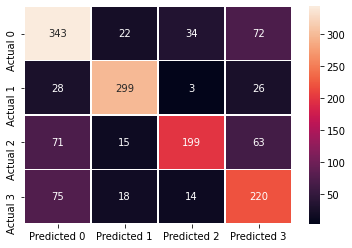

In [73]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_01.predict(padded_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'], 
            yticklabels=['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])

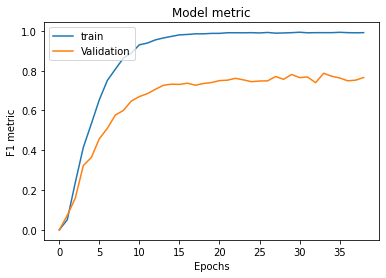

In [74]:
plt.plot(h1.history['f1_m'][1:])
plt.plot(h1.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('Epochs')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

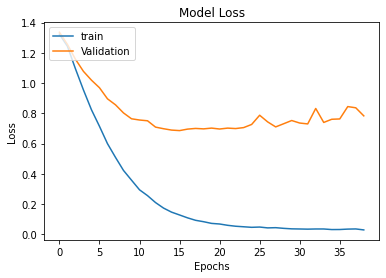

In [75]:
plt.plot(h1.history['loss'][1:])
plt.plot(h1.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

# Dataset - II

In [76]:
data = pd.read_csv('/kaggle/input/tweets/cleaned_data_kaggle.csv')
data.head()

,text,emotions
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love


In [77]:
data['emotions'].value_counts()

joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: emotions, dtype: int64

In [78]:
data['emotions'] = data['emotions'].apply(lambda x: ['joy', 'sadness', 'anger', 'fear', 'love', 'surprise'].index(x))

data['text'] = data['text'].apply(str)

In [79]:
X_s = data['text'].values
y_s = data['emotions'].values

X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.2, random_state=42, stratify=y_s)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [80]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 90282, 1: 77559, 2: 36683, 3: 30536, 4: 22114, 5: 9583}

In [81]:
unique, counts = np.unique(y_cv, return_counts=True)
dict(zip(unique, counts))

{0: 22571, 1: 19390, 2: 9171, 3: 7634, 4: 5529, 5: 2395}

In [82]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 28214, 1: 24238, 2: 11463, 3: 9542, 4: 6911, 5: 2994}

In [83]:
t = Tokenizer()
t.fit_on_texts(X_train)
vocab_size = len(t.word_index) + 1
print(vocab_size)

61189


In [84]:
encoded_train = t.texts_to_sequences(X_train)
encoded_cv = t.texts_to_sequences(X_cv)
encoded_test = t.texts_to_sequences(X_test)

In [85]:
maxLen = -1
lens = []
for x in X_s:
    
    lens.append(len(x))
    if len(x) > maxLen:
        maxLen = max(maxLen, len(x))
        
print(maxLen)

830


In [86]:
np.percentile(lens, 99.99)

300.0

In [87]:
max_length = 300
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_cv = pad_sequences(encoded_cv, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')

In [88]:
y_train = to_categorical(y_train, num_classes=6)
y_cv = to_categorical(y_cv, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)

In [89]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 200))
for word, i in t.word_index.items():
    try:
        embedding_vector = embeddings_index[word]
    except:
        embedding_vector = [0]*200
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

(61189, 200)

In [90]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=3, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=2, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(150, activation='relu', name='fully_connected')(flatten)
out = Dense(6, activation='softmax')(dense)

model_02 = Model(inputs=[input_data], outputs=[out])

print(model_02.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 300)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 300, 200)          12237800  
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 298, 50)           30050     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 149, 50)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 148, 100)          10100     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 74, 100)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 7400)              0   

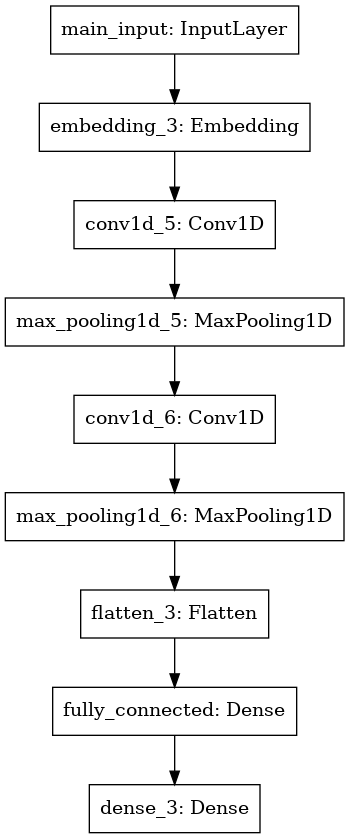

In [91]:
keras.utils.vis_utils.pydot = pyd
plot_model(model_01, to_file='model_02.png')

In [92]:
reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("emotion_model_2_1.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 5,
                            verbose=1)

In [93]:
c = optimizers.Adam(lr = 0.0001)
model_02.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

h2 = model_02.fit(padded_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, callbacks=[checkpoint, earlystop, reduce_lr], 
                 validation_data=(padded_cv, y_cv))

Train on 266757 samples, validate on 66690 samples
Epoch 1/50
266757/266757 [==============================] - 27s 101us/step - loss: 0.7990 - f1_m: 0.6577 - acc: 0.7103 - val_loss: 0.4467 - val_f1_m: 0.8374 - val_acc: 0.8389

Epoch 00001: val_f1_m improved from -inf to 0.83743, saving model to emotion_model_2_1.h5
Epoch 2/50
266757/266757 [==============================] - 28s 103us/step - loss: 0.3452 - f1_m: 0.8721 - acc: 0.8734 - val_loss: 0.2898 - val_f1_m: 0.8894 - val_acc: 0.8897

Epoch 00002: val_f1_m improved from 0.83743 to 0.88944, saving model to emotion_model_2_1.h5
Epoch 3/50
266757/266757 [==============================] - 27s 100us/step - loss: 0.2448 - f1_m: 0.9016 - acc: 0.9012 - val_loss: 0.2300 - val_f1_m: 0.9038 - val_acc: 0.9033

Epoch 00003: val_f1_m improved from 0.88944 to 0.90382, saving model to emotion_model_2_1.h5
Epoch 4/50
266757/266757 [==============================] - 27s 103us/step - loss: 0.1984 - f1_m: 0.9143 - acc: 0.9139 - val_loss: 0.2041 - val_f

In [94]:
score_2 = model_02.evaluate(padded_test, y_test)
score_2

83362/83362 [==============================] - 8s 91us/step


[0.15805572257759626, 0.915330708026886, 0.9151291847229004]

[[26693   195   123    63   974   166]
 [  163 23180   445   403    29    18]
 [   73   452 10519   395    20     4]
 [   50   256   282  8574    11   369]
 [ 1650    27    13     3  5216     2]
 [  235    31     9   606     8  2105]]


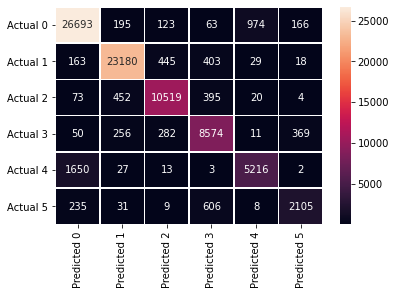

In [97]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_02.predict(padded_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3', 'Predicted 4', 'Predicted 5'], 
            yticklabels=['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3', 'Actual 4', 'Actual 5'])

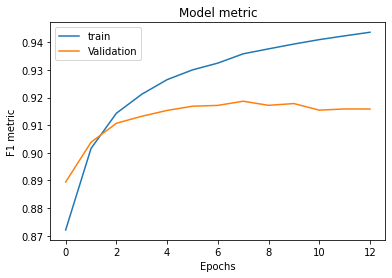

In [98]:
plt.plot(h2.history['f1_m'][1:])
plt.plot(h2.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('Epochs')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

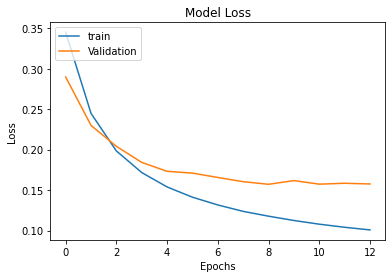

In [99]:
plt.plot(h2.history['loss'][1:])
plt.plot(h2.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','Validation'], loc='upper left')
plt.show()